# Road Pathfinder with Capacity Contraints

In [1]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [2]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'

## Road Model

In [3]:
sm = stepmodel.read_zippedpickles(model_folder + '/{scen}/aon_pathfinder'.format(scen=scenario))

distribution = stepmodel.read_zippedpickles(model_folder + '/{scen}/distribution'.format(scen=scenario))
sm.volumes = distribution.volumes

volumes: 100%|██████████| 3/3 [00:00<00:00, 1024.92it/s]


In [4]:
# Each link can have its own capacity
sm.road_links['capacity'] = 2000

# Keep relevant OD
v = sm.volumes.set_index(['origin', 'destination'])["car_owner"]
od_set = set(v.loc[v>1].index)

# Iterative Road Patfinder

In [5]:
constrained = sm.copy()
free = sm.copy()

constrained.step_road_pathfinder(method='BFW',
                             tolerance=0.01,
                             maxiters=50,
                             od_set=od_set,
                             volume_column='car_owner',
                             log=True,
                             num_cores=4,
                             access_time='time')

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1688 51.295
1 0.1547 27.742
2 0.1359 13.041
3 0.1266 6.225
4 0.1375 3.562
5 0.1703 1.94
6 0.4344 1.507
7 0.8 0.701
8 0.8 0.126
9 0.8 0.027
10 0.05 0.472
11 0.2563 0.163
12 0.1531 0.187
13 0.0938 0.112
14 0.1547 0.183
15 0.1641 0.097
16 0.4797 0.065
17 0.5203 0.051
18 0.8 0.029
19 0.8 0.007


In [6]:
constrained.to_zippedpickles(model_folder + '/{scen}/constrained_road_pathfinder'.format(scen=scenario))

relgap: 100%|██████████| 33/33 [00:02<00:00, 13.21it/s]       


# PLOT

In [7]:
if manual:
    constrained.analysis_car_los()
    constrained.car_los[('car_owner', 'probability')] = 1
    constrained.step_car_assignment(volume_column='car_owner')

    free.analysis_car_los()
    free.car_los[('car_owner', 'probability')] = 1
    free.step_car_assignment(volume_column='car_owner')
    free.road_links['flow'] = free.road_links[('car_owner', 'car')].fillna(0)

AttributeError: 'LineCollection' object has no property 'scale'

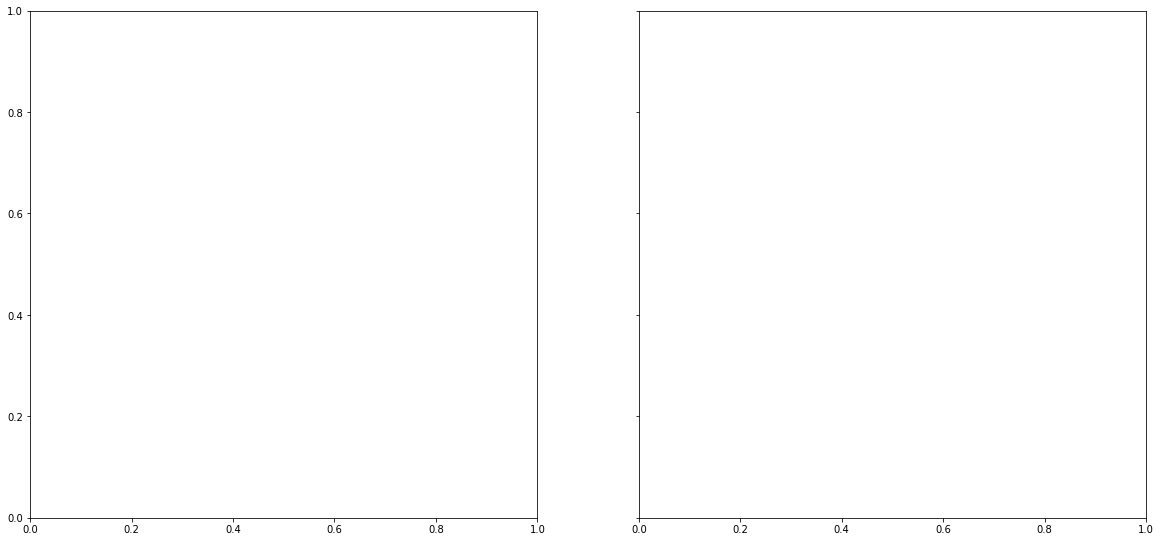

In [8]:
if manual:
    import matplotlib.pyplot as plt

    free.car_los = free.car_los.set_index(['origin', 'destination']).loc[od_set].reset_index()
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[0]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")

    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[1]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

In [ ]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)